# Estudo sobre análise de dados exploratória - EDA

- Fonte de dados: [consumidor.gov.br](https://www.consumidor.gov.br/pages/principal/?1589037000187)
- Para análise: [Indicadores](https://www.consumidor.gov.br/pages/dadosabertos/externo/)


In [61]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


plt.style.use(plt.style.available[9])

In [62]:
data = './data/2020-04.csv'

dataset = pd.read_csv(data,sep=';',encoding='latin1')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89779 entries, 0 to 89778
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Região                  89779 non-null  object 
 1   UF                      89779 non-null  object 
 2   Cidade                  89779 non-null  object 
 3   Sexo                    89779 non-null  object 
 4   Faixa Etária            89779 non-null  object 
 5   Data Finalização        89779 non-null  object 
 6   Tempo Resposta          89008 non-null  float64
 7   Nome Fantasia           89779 non-null  object 
 8   Segmento de Mercado     89779 non-null  object 
 9   Área                    89779 non-null  object 
 10  Assunto                 89779 non-null  object 
 11  Grupo Problema          89779 non-null  object 
 12  Problema                89779 non-null  object 
 13  Como Comprou Contratou  89779 non-null  object 
 14  Procurou Empresa        89779 non-null

In [63]:
dataset.columns

Index(['Região', 'UF', 'Cidade', 'Sexo', 'Faixa Etária', 'Data Finalização',
       'Tempo Resposta', 'Nome Fantasia', 'Segmento de Mercado', 'Área',
       'Assunto', 'Grupo Problema', 'Problema', 'Como Comprou Contratou',
       'Procurou Empresa', 'Respondida', 'Situação', 'Avaliação Reclamação',
       'Nota do Consumidor', 'Total'],
      dtype='object')

In [64]:
dataset.head()

,Região,UF,Cidade,Sexo,Faixa Etária,Data Finalização,Tempo Resposta,Nome Fantasia,Segmento de Mercado,Área,Assunto,Grupo Problema,Problema,Como Comprou Contratou,Procurou Empresa,Respondida,Situação,Avaliação Reclamação,Nota do Consumidor,Total
0,SE,SP,Jundiaí,M,entre 41 a 50 anos,01/04/2020,10.0,Vivo - Telefônica (GVT),"Operadoras de Telecomunicações (Telefonia, Int...",Telecomunicações,Telefonia Fixa,Atendimento / SAC,SAC - Demanda não resolvida / não respondida /...,Loja física,S,S,Finalizada não avaliada,Não Avaliada,NaN,1
1,SE,RJ,Itaguaí,F,entre 31 a 40 anos,02/04/2020,9.0,SKY,"Operadoras de Telecomunicações (Telefonia, Int...",Telecomunicações,TV por Assinatura,Cobrança / Contestação,Cobrança após cancelamento do serviço,Telefone,S,S,Finalizada não avaliada,Não Avaliada,NaN,1
2,CO,DF,Brasília,F,entre 41 a 50 anos,02/04/2020,10.0,Vivo - Telefônica (GVT),"Operadoras de Telecomunicações (Telefonia, Int...",Produtos de Telefonia e Informática,Aparelho de telefone fixo / interfone,Cobrança / Contestação,Cobrança indevida / abusiva para alterar ou ca...,Internet,S,S,Finalizada avaliada,Resolvida,1.0,1
3,NE,PI,Teresina,M,entre 21 a 30 anos,03/04/2020,10.0,Tim,"Operadoras de Telecomunicações (Telefonia, Int...",Telecomunicações,Telefonia Móvel Pós-paga,Contrato / Oferta,Oferta não cumprida / serviço não fornecido/ v...,Internet,S,S,Finalizada não avaliada,Não Avaliada,NaN,1
4,CO,DF,Brasília,M,entre 31 a 40 anos,02/04/2020,10.0,Vivo - Telefônica (GVT),"Operadoras de Telecomunicações (Telefonia, Int...",Telecomunicações,Pacote de Serviços ( Combo ),Contrato / Oferta,Oferta não cumprida / serviço não fornecido/ v...,Internet,S,S,Finalizada avaliada,Resolvida,5.0,1


## Hipóteses

### Existe uma predominância de sexo nas reclamações?

In [65]:
slices = dataset[u'Sexo'].value_counts()
slices

M    51423
F    38356
Name: Sexo, dtype: int64

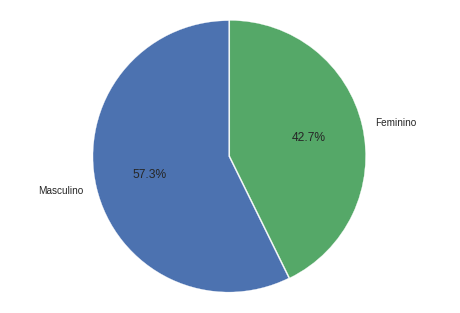

In [66]:
_, sex = plt.subplots()
sex.pie(
    slices, 
    explode=(0, 0.009), 
    labels=['Masculino', 'Feminino'], 
    autopct='%1.1f%%',
    startangle=90,
)
sex.axis('equal')
plt.show()

### Das reclamações, qual quantitativo das avaliações?

In [67]:
dataset[u'Avaliação Reclamação'].value_counts()
# dataset.groupby(u'Sexo')[u'Avaliação Reclamação'].value_counts()
# dataset.groupby(u'Avaliação Reclamação').mean()
# dataset[u'Avaliação Reclamação'].array.unique()

Não Avaliada     40149
Resolvida        29601
Não Resolvida    20029
Name: Avaliação Reclamação, dtype: int64

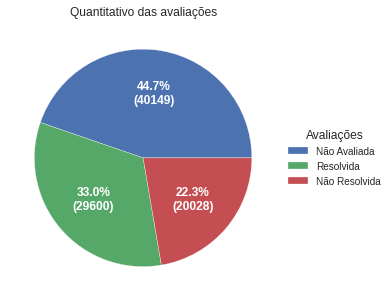

In [68]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

data = dataset[u'Avaliação Reclamação'].value_counts()
labels = dataset[u'Avaliação Reclamação'].array.unique()

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(
    data, 
    autopct=lambda pct: func(pct, data),
    textprops=dict(color="w")
)

ax.legend(
    wedges, 
    labels,
    title="Avaliações",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Quantitativo das avaliações")

plt.show()

### Qual a faixa etária média dos consumidores?

In [69]:
dataset.groupby(u'Sexo')[u'Faixa Etária'].value_counts()

Sexo  Faixa Etária      
F     entre 31 a 40 anos    11806
      entre 21 a 30 anos     9553
      entre 41 a 50 anos     6292
      entre 51 a 60 anos     4672
      entre 61 a 70 anos     3708
      mais de 70 anos        1723
      até 20 anos             602
M     entre 31 a 40 anos    18454
      entre 21 a 30 anos    13834
      entre 41 a 50 anos     8769
      entre 51 a 60 anos     4595
      entre 61 a 70 anos     3244
      mais de 70 anos        1615
      até 20 anos             912
Name: Faixa Etária, dtype: int64

### Qual o grupo de problema mais comum?

In [70]:
dataset[u'Grupo Problema'].value_counts()

Cobrança / Contestação    38532
Contrato / Oferta         17338
Atendimento / SAC         15116
Vício de Qualidade        11237
Informação                 4252
Entrega do Produto         2600
Saúde e Segurança           704
Name: Grupo Problema, dtype: int64

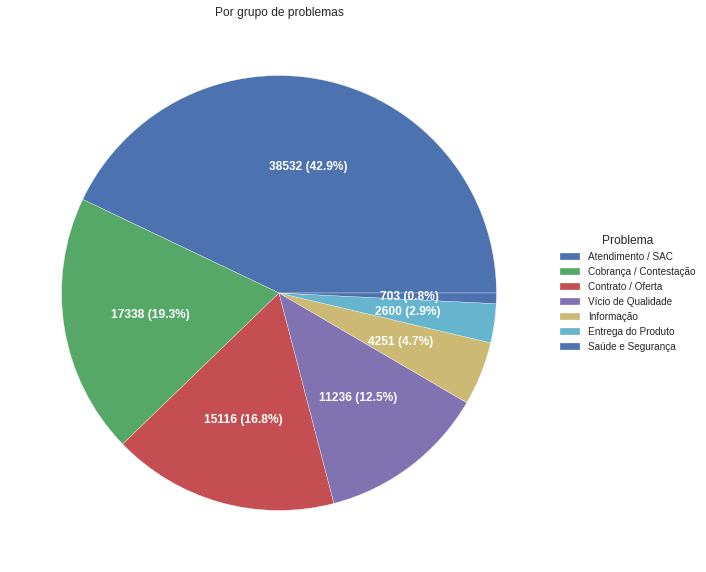

In [71]:
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))

data = dataset[u'Grupo Problema'].value_counts()
labels = dataset[u'Grupo Problema'].array.unique()


def legend(percent, all_values):
    absolute = int(percent/100.*np.sum(all_values))
    return f"{absolute:d} ({percent:.1f}%)"


wedges, texts, autotexts = ax.pie(
    data, 
    autopct=lambda percent: legend(percent, data),
    textprops=dict(color="w")
)

ax.legend(
    wedges, 
    labels,
    title="Problema",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Por grupo de problemas")

plt.show()

### Qual o segmento de mercado mais afetado?

In [72]:
is_cobranca_contestacao = dataset[u'Grupo Problema'] == u'Cobrança / Contestação'
segmento = dataset[is_cobranca_contestacao]
segmento['Segmento de Mercado'].value_counts()

Bancos, Financeiras e Administradoras de Cartão                            13384
Operadoras de Telecomunicações (Telefonia, Internet, TV por assinatura)    12795
Transporte Aéreo                                                            3592
Agências de Viagens                                                         1820
Empresas de Intermediação de Serviços / Negócios                            1355
Comércio Eletrônico                                                         1127
Energia Elétrica                                                             953
Empresas de Pagamento Eletrônico                                             933
Corretoras e Sociedades de Seguros, Capitalização e Previdência              406
Programas de Fidelidade                                                      382
Bancos de Dados e Cadastros de Consumidores                                  358
Empresas de Recuperação de Crédito                                           294
Perfumaria, Cosméticos e Hig

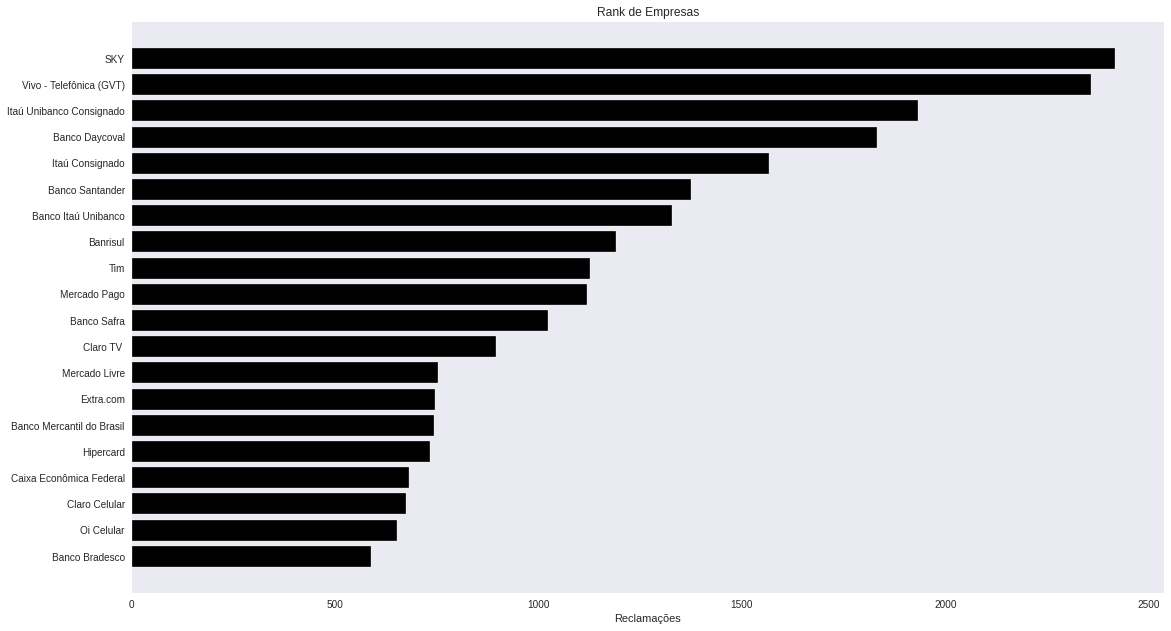

In [73]:
nome_fantasia = segmento[u'Nome Fantasia']

fig, ax = plt.subplots()

y_pos = np.arange(len(nome_fantasia.value_counts()[:20]))
values = nome_fantasia.value_counts()[:20]
segmentos = nome_fantasia.unique()[:20]

ax.barh(y_pos, values, align='center', color='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(segmentos)
ax.invert_yaxis()

ax.set_xlabel('Reclamações')
ax.set_title('Rank de Empresas')
ax.grid()

fig.set_size_inches(18.5, 10.5, forward=False)
plt.rcParams.update({'font.size': 15})

plt.show()

### Existe alguma correlação entre o tempo de resposta e a nota do consumidor?


Para tentar validar essa suposição, utilizar o Coeficiente de Correlação de Pearson.

A técnica basicamente mede o grau de correlação e sua direção entre duas variáveis de escala métrica.

O coeficiente assume valores entre -1  e 1 onde o valor 1 indica uma correlação perfeitamente positiva entre as duas variáveis, -1 indica uma correlação perfeitamente negativa e o valor 0 representa que não existe correlação linear entre as variáveis.

Voltando para o nosso contexto, uma correlação negativa alta com valores entre -0.7 a -0.9 pode indicar que quanto menor o tempo de resposta maior a nota atribuída à empresa pelo consumidor.

Levando em consideração a existência de uma correlação negativa o valor do tempo de resposta deve diminuir e a nota do consumidor aumentar.

Tempo Resposta        7.0
Nota do Consumidor    3.0
dtype: float64
                    Tempo Resposta  Nota do Consumidor
Tempo Resposta             1.00000            -0.10299
Nota do Consumidor        -0.10299             1.00000


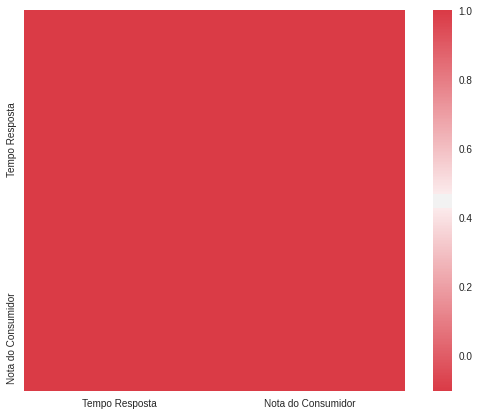

In [74]:
f, ax = plt.subplots(figsize=(10, 7))

corr_dataset = dataset

corr_dataset = corr_dataset.drop('Total',axis=1) # Exclui a coluna Total da base de dados

print(corr_dataset.median())

'''
Definindo a correlação entre as variáveis: 
 - O método corr do pandas faz o cálculo de correlação entre as variáveis numéricas em todo o dataframe.
'''
corr = corr_dataset.corr()

sns.heatmap(
    corr, 
    mask=np.zeros_like(corr, dtype=np.bool), 
    cmap=sns.diverging_palette(10, 10, as_cmap=True), 
    square=True, 
    ax=ax
)
print(corr)

### Qual a proporção de reclamações registradas e que não são resolvidas?

In [75]:
# Separa e agrupa por segmento
x = dataset.groupby(u'Segmento de Mercado')[u'Segmento de Mercado'].count()

#Filtrando os segmentos de mercado com mais de 20 reclamações
reclamacoes = x[x > 20]

# Filtra novamente os dados especificando apenas os segmentos selecionados e armazenados em x
# isin() permite filtrar um atributo a apenas aos valores igual aos valores passados por parâmetro.
df = dataset[dataset[u'Segmento de Mercado'].isin(reclamacoes.keys())]

# Das reclamações, soma as não resolvidas
nao_resolvidas = df[df[u'Avaliação Reclamação']==u'Não Resolvida']
reclamacoes_nao_resolvidas = nao_resolvidas.groupby(u'Segmento de Mercado')[u'Segmento de Mercado'].count()

# Das reclamações, soma as resolvidas
resolvidas = df[df[u'Avaliação Reclamação']==u'Resolvida']
reclamacoes_resolvidas = resolvidas.groupby(u'Segmento de Mercado')[u'Segmento de Mercado'].count()

# Das reclamações, soma as resolvidas
nao_avaliadas = df[df[u'Avaliação Reclamação']==u'Não Avaliada']
reclamacoes_nao_avaliadas = nao_avaliadas.groupby(u'Segmento de Mercado')[u'Segmento de Mercado'].count()

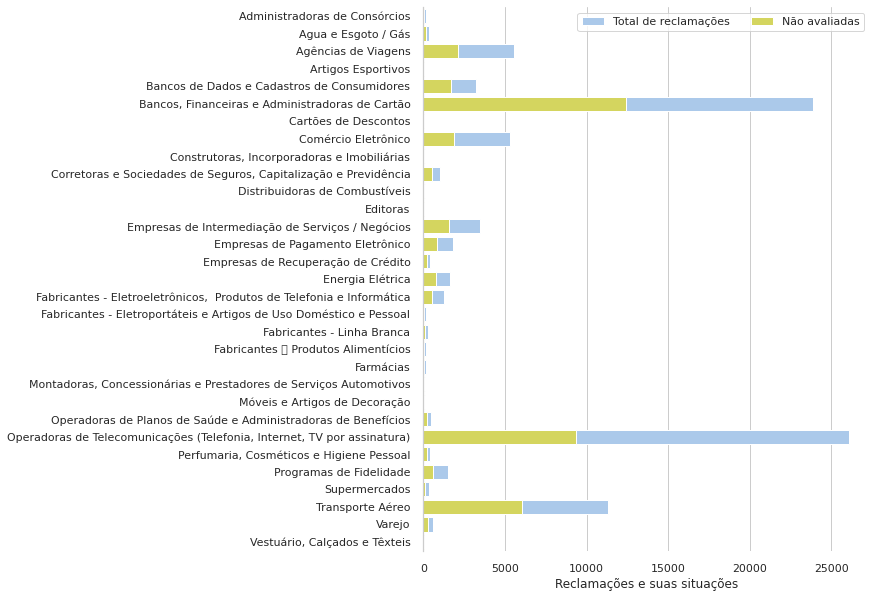

In [84]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

f, ax = plt.subplots(figsize=(8, 10))

sns.barplot(
    x=reclamacoes.values, 
    y=reclamacoes.keys(), 
    label="Total de reclamações", 
    color="b"
)


sns.barplot(
    x=reclamacoes_nao_avaliadas.values, 
    y=reclamacoes_nao_avaliadas.keys(),
    label="Não avaliadas", 
    color="#E7E84C"
)

ax.legend(ncol=2, loc="best", frameon=True)
ax.set(ylabel="", xlabel="Reclamações e suas situações")

sns.despine(left=False, bottom=True)

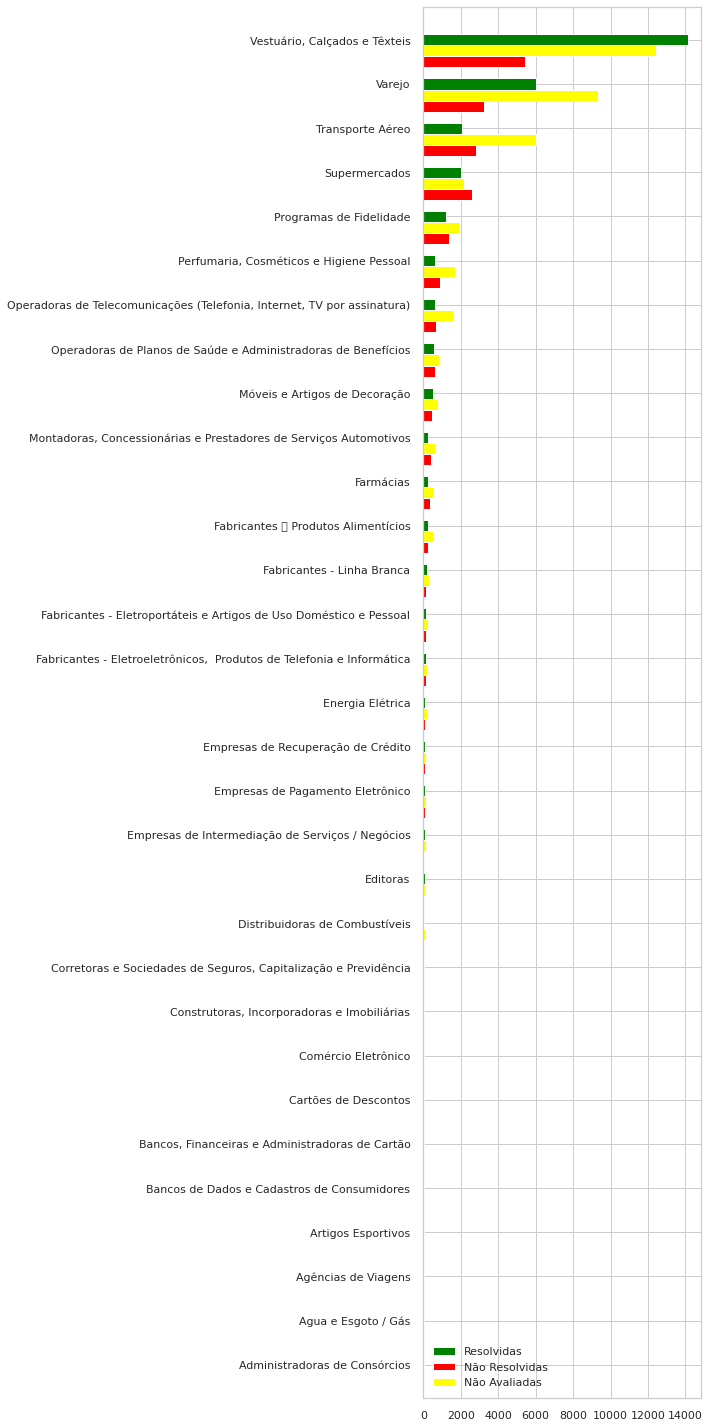

In [77]:
index = reclamacoes.keys()

df = pd.DataFrame(
    dict(
        graph=reclamacoes.keys(),
        total=reclamacoes.values,
        resolvidas=reclamacoes_resolvidas.values,
        nao_resolvidas=reclamacoes_nao_resolvidas.values,
        nao_avaliadas=reclamacoes_nao_avaliadas.values,
    )
) 

x_index = np.arange(len(df))
heigth = 0.25

fig, ax = plt.subplots(
    figsize=(10, 20)
)


ax.barh(x_index + heigth, df.resolvidas.sort_values(), heigth, color='green', label='Resolvidas')
ax.barh(x_index - heigth, df.nao_resolvidas.sort_values(), heigth, color='red', label='Não Resolvidas')
ax.barh(x_index, df.nao_avaliadas.sort_values(), heigth, color='yellow', label='Não Avaliadas')

ax.set(
    yticks=x_index + heigth, 
    yticklabels=df.graph, 
    ylim=[2*heigth - 1, len(df)]
)

ax.legend()

plt.tight_layout()

plt.show()

### As reclamações são distribuídas em todo Brasil, ou existe uma maior concentração em determinadas regiões?

In [78]:
municipios = pd.read_excel('./data/brasil_municipios.xls', encoding='latin1')
municipios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5509 entries, 0 to 5508
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         5509 non-null   int64  
 1   LATITUDE   5509 non-null   object 
 2   LONGITUDE  5509 non-null   float64
 3   Mun/UF     5509 non-null   object 
 4   MUNICIPIO  5509 non-null   object 
 5   UF         5509 non-null   object 
 6   Valor      5509 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 301.4+ KB


In [79]:
municipios.head()

,ID,LATITUDE,LONGITUDE,Mun/UF,MUNICIPIO,UF,Valor
0,1,LATITUDE,-66.88,Mun/UF,ACRELANDIA,AC,39560.038911
1,2,-10.94,-69.56,ASSIS BRASIL - AC,ASSIS BRASIL,AC,17842.150989
2,3,-11.01,-68.74,BRASILEIA - AC,BRASILEIA,AC,93373.394313
3,4,-9.83,-67.95,BUJARI - AC,BUJARI,AC,28516.567493
4,5,-10.57,-67.67,CAPIXABA - AC,CAPIXABA,AC,18886.455136


In [80]:
municipios.UF.value_counts().sort_values()

DF      1
RR     15
AP     16
AC     22
RO     52
AM     62
SE     75
ES     77
MS     77
RJ     91
AL    101
MT    126
TO    139
PA    143
RN    166
CE    184
PE    185
MA    217
PI    221
PB    223
GO    242
SC    293
PR    399
BA    415
RS    469
SP    645
MG    853
Name: UF, dtype: int64

In [81]:
import unicodedata
import re

def remover_acentos(txt):
    nfkd = unicodedata.normalize('NFKD', txt)
    palavra_sem_acento = u"".join([c for c in nfkd if not unicodedata.combining(c)])
    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    palavra_sem_acento = re.sub('[^a-zA-Z0-9 \\\]', '', palavra_sem_acento)
    palavra_sem_acento = str(palavra_sem_acento).upper()
    return palavra_sem_acento

dataset['Cidade2'] = dataset['Cidade'].apply(remover_acentos)

dataset['Cidade2']

0          JUNDIAI
1          ITAGUAI
2         BRASILIA
3         TERESINA
4         BRASILIA
           ...    
89774    SAO PAULO
89775    SAO PAULO
89776    SAO PAULO
89777       SUZANO
89778    SAO PAULO
Name: Cidade2, Length: 89779, dtype: object

In [85]:
# import folium
# from folium import plugins

# mapa = folium.Map(location=[-15.788497,-47.879873],zoom_start=5,tiles='Stamen Toner')
# coordenadas=[]

# for cid,uf in zip(dataset.Cidade2[:20000],dataset.UF[:20000]):
#     cidadeUf = cid+' - '+uf
#     lat = municipios[municipios['Mun/UF'] == cidadeUf]['LATITUDE'].values
#     long = municipios[municipios['Mun/UF'] == cidadeUf]['LONGITUDE'].values
    
#     if lat != '' and long != '':
#         lat = float(str(lat).replace('[','').replace(']','').replace(' ',','))
#         long = float(str(long).replace('[','').replace(']','').replace(' ',','))
    
#         coordenadas.append([lat,long])
    
#     mapa.add_child(plugins.HeatMap(coordenadas))

# mapa